In [78]:
# Librerias
import os
from bs4 import BeautifulSoup
from unidecode import unidecode
import datetime
import traceback
import json
import csv
import pandas as pd
import jellyfish
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt

In [79]:
# Parámetros
sourceDataFolder = "1-source-data"

emailsRootPath = sourceDataFolder + r"\support\email"
covidRootPath = sourceDataFolder + r"\support\covid"
gysAdRootPath = sourceDataFolder + r"\support\gys-ad"
azureAdRootPath = sourceDataFolder + r"\support\azure-ad"
inHomeRootPath = sourceDataFolder + r"\support\in-home"
mastersRootPath = sourceDataFolder + r"\masters"

intermFilesFolder = "2-intermediate-files"
resultsFolder = "3-results"
logsFolder = "4-logs"

dataVisualizationTopLimit = 20

counterIn = 0
counterOut = 0

In [80]:
# Funciones utilitarias
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def parseLineBreaksAndAccents(text):
  return unidecode(" ".join(text.split()))

def parseNames(text):
  return text.strip().title()

def findTags(tag, color):
  return tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color })

def getChildIndex(mainChildTags, title, color):
  return next((index for index, tag in enumerate(mainChildTags) if ( findTags(tag, color).text == title if findTags(tag, color) else False )), None)

def getSectionsIndexes(mainChildTags, color):
  sectionsIndexes = []
  sectionsTitle = ["Experiencia laboral", "Educación", "Informática", "Idiomas", "Otros Conocimientos"]
  
  for sectionTitle in sectionsTitle:
    sectionIndex = getChildIndex(mainChildTags, sectionTitle, color)
    sectionsIndexes.append(sectionIndex)
  
  sectionsIndexes.append(len(mainChildTags)-1)
  return sectionsIndexes

def getNextSectionIndexValid(sectionsIndexes, i):
  while(not sectionsIndexes[i]):
    i = i + 1

  return sectionsIndexes[i]

def readJson(path, encoding='utf-8', errors=None):
  with open (path, "r", encoding=encoding, errors=errors) as f:
    data = json.loads(f.read())
  return data

def writeJson(data, pathJson, encoding='utf-8'):
  with open(pathJson, 'w', encoding=encoding) as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

def writeCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeTxt(data, pathTxt, encoding='utf-8'):
  with open(pathTxt, 'w', encoding=encoding) as f:
    f.write(data)

def readSupport(file, readEncoding = 'utf-8'):
  with open(os.path.join(file), "r", encoding=readEncoding) as file:
    data = [{k: parseNames(v) for k, v in row.items()} for row in csv.DictReader(file, skipinitialspace=True)]

  return data

def readAndWriteSupport(folder, file, writeFileName, readEncoding = 'utf-8', writeEncoding = 'utf-8'):
  with open(os.path.join(folder, file), "r", encoding=readEncoding) as file:
    data = [{k: parseNames(v) for k, v in row.items()} for row in csv.DictReader(file, skipinitialspace=True)]

  with open(os.path.join(intermFilesFolder, writeFileName), 'w', encoding=writeEncoding) as file:
    json.dump(data, file, indent=4, ensure_ascii=False)
  
  return data

def getCompare(data, fields):
  return (list(set([" ".join(x for x in [elem[y] for y in fields] if x) for elem in data if elem])))

In [81]:
def readAndWriteInHome(folder, writeFileName):
  folderFiles = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

  attendees = []
  
  for file in folderFiles:
    # Detectar si tienen el To: en el texto
    try:
      # Detectar el encoding
      encoding = "utf-16"
      with open(file, "r") as f:
        encoding = 'windows-1252' if "charset=windows-1252" in f.read() else 'utf-16'

      # El .read() manda el cursor al final del archivo, por eso si se usa 2 veces, la 2da vez no encuentra nada
      with open(file, "r", encoding=encoding) as f:
        soup = BeautifulSoup(f.read(), "lxml")
        #print(str(soup))
        # El soup.text le quita las etiquetas
        if '<span style="color:black">To:<span style="mso-tab-count:1">' in parseLineBreaksAndAccents(str(soup)):
          allAttendees = parseLineBreaksAndAccents(soup.find_all("span", {"style": 'color:black'})[5].text)
          attendeesList = allAttendees.split("; ")
          attendees.extend(attendeesList)
    except Exception as e:
      print(file)
      traceback.print_exc()
      print()
      pass

  data = [ {"name": parseNames(participant)} for participant in attendees ]

  with open(os.path.join(intermFilesFolder, writeFileName), 'w', encoding='utf-8') as file:
    json.dump(data, file, indent=4, ensure_ascii=False)

  return data

In [82]:
def readAndWritePreprocessedData(mergedMainData, masters):
  for elem in mergedMainData:
    for profileName in masters[0]:
      if elem["profileName"] == profileName["profileName"]:
        elem["primaryRole"] = profileName["primaryRole"]
        elem["secondaryRole"] = profileName["secondaryRole"]
        elem["companyArea"] = profileName["companyArea"]
        elem["profileLevel"] = profileName["profileLevel"]

  # Eliminando el puesto de trabajo anterior
  mergedMainData = [{key:value for key, value in elem.items() if key not in ["profileName"]} for elem in mergedMainData]

  return mergedMainData

In [83]:
def readAndWriteFinalTaggedData(preprocessedData, emailsData, covidData, gysAdData, azureAdData, inHomeData):
  # Definiendo arrays con el nombre
  arrayNames = [
    getCompare(emailsData, ["nombreParaMostrar"]),
    getCompare(emailsData, ["primerNombre", "apellidoPaterno"]),
    getCompare(emailsData, ["segundoNombre", "apellidoPaterno"]),
    getCompare(emailsData, ["primerNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(emailsData, ["segundoNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(emailsData, ["primerNombre", "segundoNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(covidData, ["nombreParaMostrar"]),
    getCompare(covidData, ["primerNombre", "apellidoPaterno"]),
    getCompare(covidData, ["segundoNombre", "apellidoPaterno"]),
    getCompare(covidData, ["primerNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(covidData, ["segundoNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(covidData, ["primerNombre", "segundoNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(gysAdData, ["Nombre para mostrar"]),
    getCompare(gysAdData, ["Nombre", "Apellido"]),
    getCompare(azureAdData, ["displayName"]),
    getCompare(azureAdData, ["givenName", "surname"]),
    getCompare(inHomeData, ["name"]),
  ]

  # Leyendo la data de contratados
  sensitivity = 0.84

  for row in preprocessedData:
    for arrayName in arrayNames:
      for elem in arrayName:
        distance = jellyfish.jaro_distance(row["candidateName"], elem)
        if (distance >= sensitivity):
          row["hired"] = 1
          break
      if "hired" not in row:
        row["hired"] = 0
  
  writeJson(preprocessedData, os.path.join(resultsFolder, 'result.json'), 'utf-8')
  writeCsv(preprocessedData, os.path.join(resultsFolder, 'result.csv'), 'utf-8')

  return preprocessedData


In [84]:
def visualizeData(mergedMainData):
  df = pd.DataFrame(mergedMainData)

  print(df.count())

  columns = [elem for elem in df.columns if elem not in ["postulationDate", "candidateName"]] 

  for column in columns:
    top10 = df[column].value_counts()[:dataVisualizationTopLimit]
    print(top10)
    y_axis = list(reversed(top10.index))
    x_axis = list(reversed(top10.values))
    plt.ylabel(column)
    plt.barh(y_axis, x_axis)
    plt.show()

In [85]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))
  print("Se inició el procesamiento")

  # Leyendo la data obtenida en el entendimiento de los datos
  mergedMainData = readJson(os.path.join(sourceDataFolder, 'result.json'))

  # Definiendo variables booleanas para leer o leer y procesar los archivos de apoyo
  isLoadedEmailData = True
  isLoadedCovidData = True
  isLoadedGysAdData = True
  isLoadedAzureAdData = True
  isLoadedInHomeData = True
  isPreprocessed = False
  isFinalTaggedData = True

  # Leyendo el archivo de correos
  emailsData = readJson(os.path.join(intermFilesFolder, 'email.json')) if isLoadedEmailData else readAndWriteSupport(emailsRootPath, 'email.csv', 'email.json', 'windows-1252')
  print("Se terminó de procesar email")

  # Leyendo el archivo de covid
  covidData = readJson(os.path.join(intermFilesFolder, 'covid.json')) if isLoadedCovidData else readAndWriteSupport(covidRootPath, 'covid.csv', 'covid.json', 'windows-1252')
  print("Se terminó de procesar covid")

  # Leyendo el archivo de gys AD
  gysAdData = readJson(os.path.join(intermFilesFolder, 'gys-ad.json')) if isLoadedGysAdData else readAndWriteSupport(gysAdRootPath, 'gys-ad.csv', 'gys-ad.json', readEncoding='utf-8-sig')
  print("Se terminó de procesar gysAd")

  # Leyendo el archivo de azure AD
  azureAdData = readJson(os.path.join(intermFilesFolder, 'azure-ad.json')) if isLoadedAzureAdData else readAndWriteSupport(azureAdRootPath, 'azure-ad.csv', 'azure-ad.json', readEncoding='utf-8-sig')
  print("Se terminó de procesar azureAd")

  # Leyendo el archivo de inHome
  inHomeData = readJson(os.path.join(intermFilesFolder, 'in-home.json')) if isLoadedInHomeData else readAndWriteInHome(inHomeRootPath, 'in-home.json')
  print("Se terminó de procesar inHome")

  # Preprocesamiento de datos
  # Leyendo archivos maestros
  profileNameMaster = readSupport(os.path.join(mastersRootPath, 'profileName.csv'))

  # Aplicando los datos de los maestros y validaciones
  preprocessedData = readJson(os.path.join(intermFilesFolder, 'result.json')) if isPreprocessed else readAndWritePreprocessedData(mergedMainData, [profileNameMaster])
  print("Se terminó el preprocesamiento")

  # Asignando la variable objetivo
  """finalTaggedData = readJson(os.path.join(resultsFolder, 'result.json')) if isFinalTaggedData else readAndWriteFinalTaggedData(mergedMainData, emailsData, covidData, gysAdData, azureAdData, inHomeData)
  print("Se terminó de procesar la data final")"""

  visualizeData(preprocessedData)

  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

Inicio: 2023-05-12 02:20:15.835446
Se inició el procesamiento
Se terminó de procesar email
Se terminó de procesar covid
Se terminó de procesar gysAd
Se terminó de procesar azureAd
Se terminó de procesar inHome
Se terminó el preprocesamiento
postulationDate      6216
candidateName        6216
residenceCountry     6216
lastWorkCenter       6216
lastWorkPosition     6216
yearsOfExperience    6216
worksNumber          6216
studyCenter          6216
careerField          6216
careerStatus         6216
careerDegree         6216
studiesNumber        6216
technicalSkills      6216
languages            6216
anotherSkills        6216
salary               6216
primaryRole          6216
secondaryRole        6216
companyArea          6216
profileLevel         6216
dtype: int64
Peru                    6085
Venezuela                109
Argentina                  9
Brasil                     3
Colombia                   3
Ecuador                    2
Republica Dominicana       1
Francia                

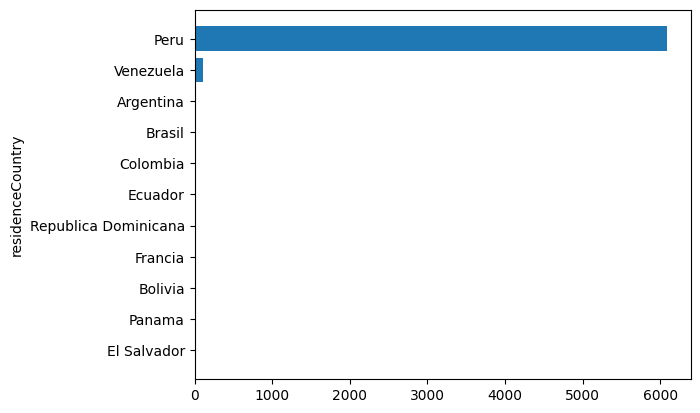

Canvia                                      86
Freelance (Clientes)                        78
Independiente                               42
Global Hitss                                40
Everis                                      39
Indra                                       38
Mdp Consulting                              37
Everis Peru Sac                             29
Tata Consultancy Services                   23
Pontificia Universidad Catolica Del Peru    21
Tivit                                       21
Experis                                     20
Banco De Credito Del Peru                   18
Autoridad Nacional Del Agua                 18
Softtek                                     17
Interbank                                   16
Freelance                                   16
Alicorp                                     15
Telefonica Del Peru                         15
Everis Peru                                 15
Name: lastWorkCenter, dtype: int64


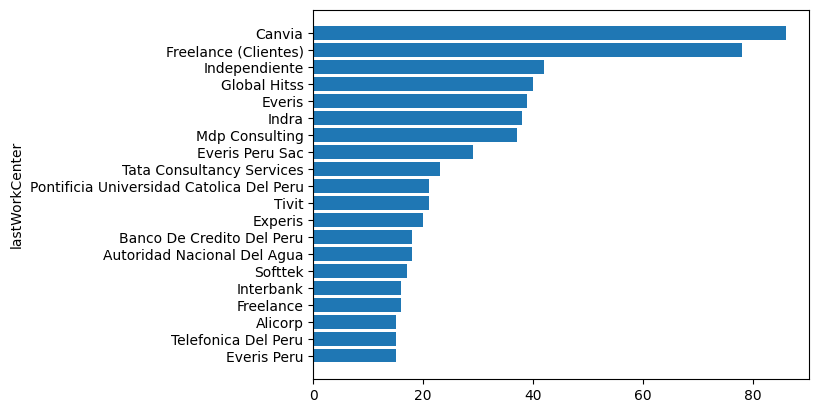

Analista Programador                            235
Analista De Sistemas                            118
Analista Funcional                               80
Supervisor De Infraestructura De Redes Cisco     78
Jefe De Proyectos                                61
Project Manager                                  52
Analista                                         39
Trabajadora Social                               35
Jefe De Sistemas                                 30
Asistente Administrativo                         28
Ejecutivo Comercial                              27
Practicante                                      26
Asistente De Sistemas                            26
Data Engineer                                    26
Asistente De Recursos Humanos                    26
Analista Qa                                      25
Key Account Manager                              25
Analista Desarrollador                           23
Asesor Comercial                                 23
Analista Pro

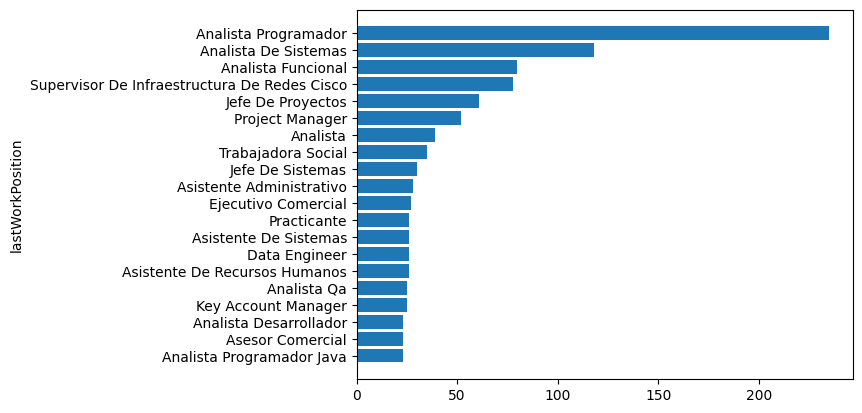

5     490
4     475
8     456
6     450
7     418
2     374
9     373
3     357
10    351
1     315
11    291
0     246
13    215
12    210
15    202
14    179
16    129
17     97
18     89
19     84
Name: yearsOfExperience, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_1640\1267574479.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


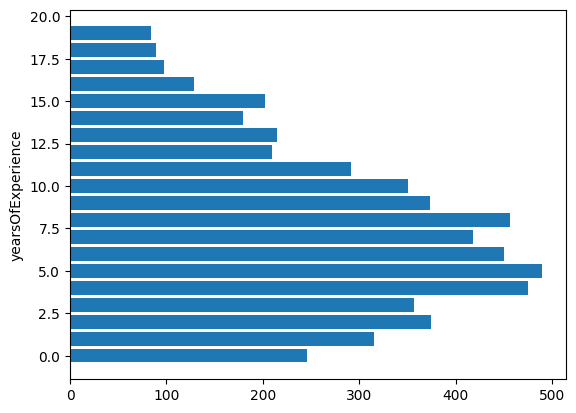

5     855
6     769
4     752
7     674
3     546
8     512
9     385
2     369
10    322
1     222
11    207
12    202
13    118
14    105
15     61
17     29
16     28
18     17
19     12
21      8
Name: worksNumber, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_1640\1267574479.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


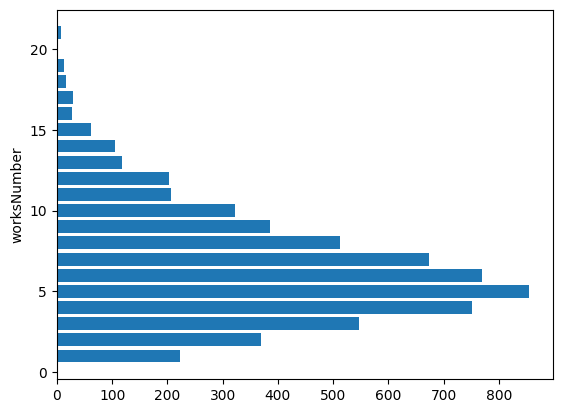

Universidad Peruana De Ciencias Aplicadas    347
Universidad Tecnologica Del Peru             215
Pontificia Universidad Catolica Del Peru     212
Universidad Nacional Mayor De San Marcos     176
Universidad Esan                             172
Universidad Privada Del Norte                147
Upc                                          137
Universidad Nacional De Ingenieria           132
Cibertec                                     129
Universidad Ricardo Palma                    124
Universidad De Lima                          116
Universidad Cesar Vallejo                    115
Instituto Cibertec                           111
Universidad Nacional Federico Villarreal     109
Universidad De San Martin De Porres          100
Isil                                          98
Universidad San Ignacio De Loyola             95
Universidad Inca Garcilaso De La Vega         90
Tecsup                                        89
Utp                                           84
Name: studyCenter, d

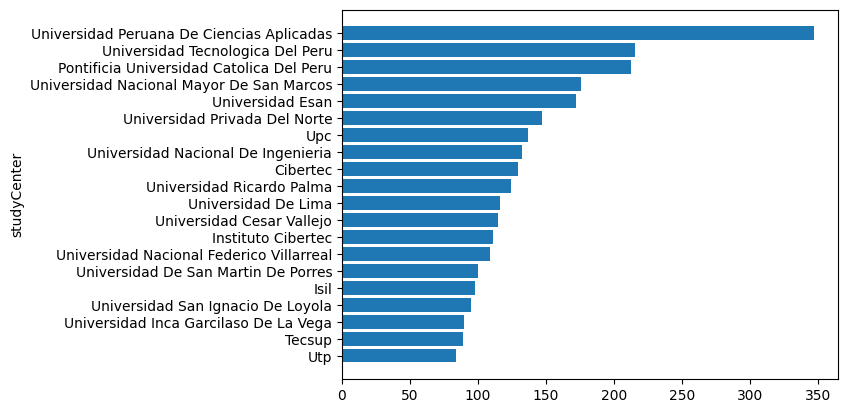

Ing. En Sistemas                  1450
Tecnologias De La Informacion      953
Adm. De Empresas                   645
Ing. Informatica                   373
Ing. Industrial                    308
Computacion / Informatica          263
Otra                               247
Marketing / Comercializacion       238
Recursos Humanos / Relac. Ind.     206
Ing. - Otros                       125
Psicologia                         114
Telecomunicaciones                  90
Ing. Telecomunicaciones             87
Analisis De Sistemas                84
Procesos / Calidad Total            78
Programacion                        74
Trabajo Social                      65
Finanzas                            64
Ing. Electronica                    58
Bachiller                           53
Name: careerField, dtype: int64


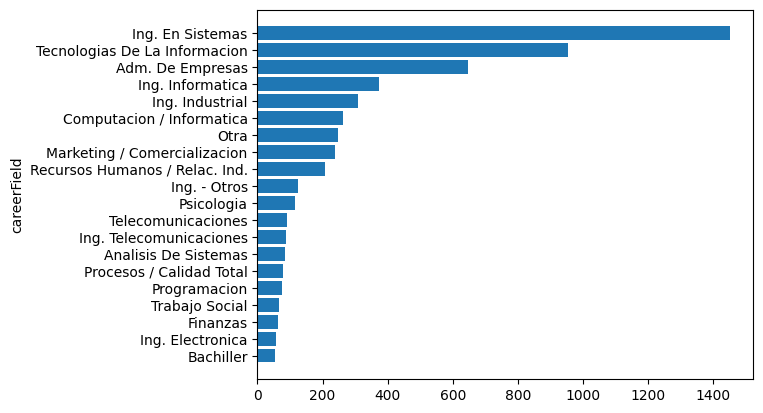

Graduado      4381
En Curso      1761
Abandonado      74
Name: careerStatus, dtype: int64


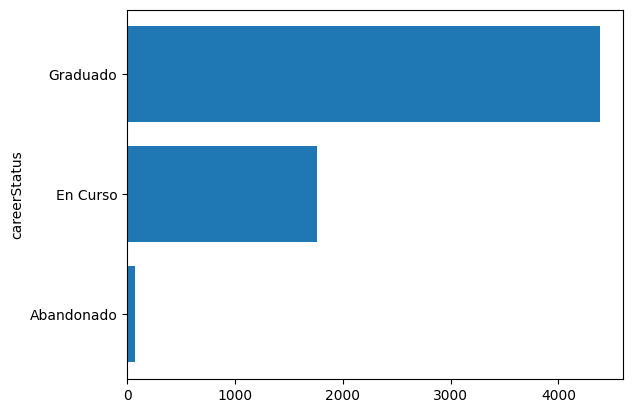

Universitario        2729
Otro                 1624
Posgrado              888
Terciario/Tecnico     509
Master                450
Doctorado              13
Secundario              3
Name: careerDegree, dtype: int64


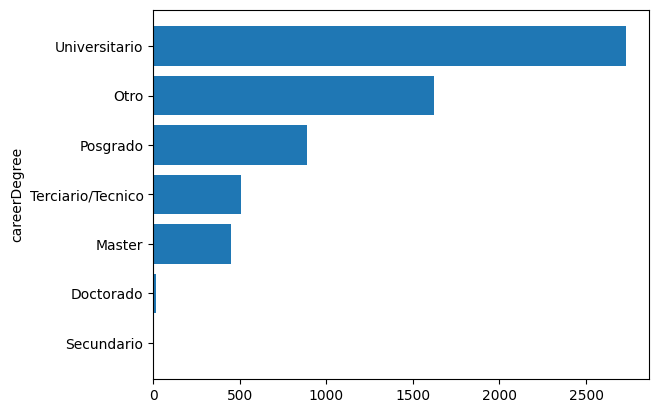

1     1858
2     1414
3      827
4      499
6      335
5      322
7      240
8      149
9      116
11      86
10      80
12      61
14      45
13      36
16      23
15      19
20      18
18      16
19      14
17      14
Name: studiesNumber, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_1640\1267574479.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


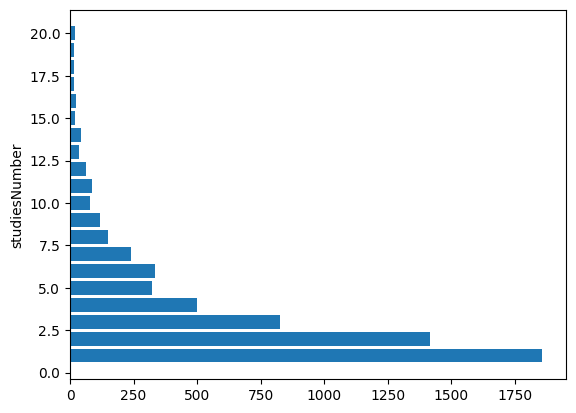

1     664
3     543
2     495
4     429
5     410
6     350
7     336
9     335
8     315
10    255
11    246
13    197
12    197
16    185
14    134
15    113
18     95
17     93
21     77
19     68
Name: technicalSkills, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_1640\1267574479.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


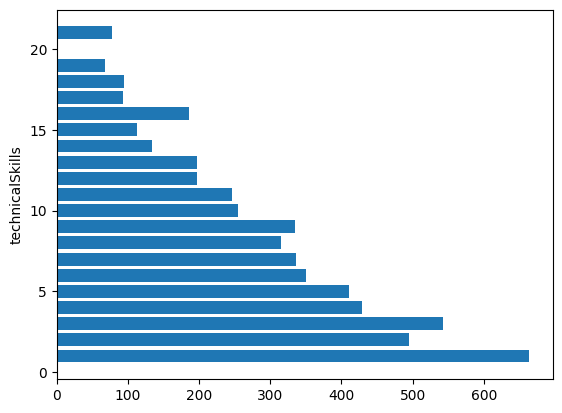

1    4656
2    1288
3     197
4      51
0      23
5       1
Name: languages, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_1640\1267574479.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


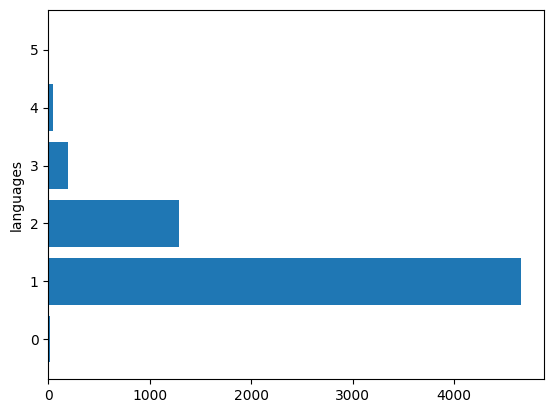

1     1288
2      904
3      650
4      593
5      536
6      405
7      353
8      291
9      223
10     182
11     147
12     117
13      93
14      69
15      64
17      42
16      35
20      31
19      25
23      22
Name: anotherSkills, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_1640\1267574479.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


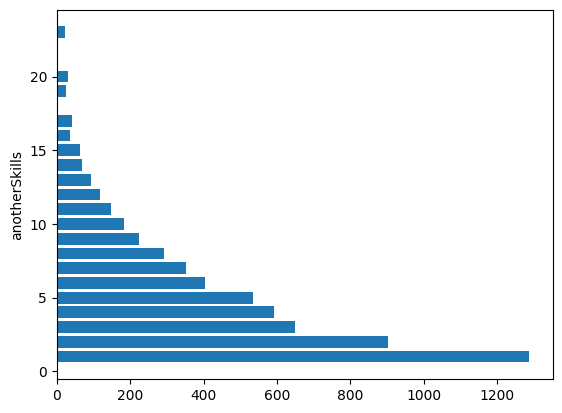

5000     413
2500     391
3500     381
3000     370
4000     369
2000     351
6000     347
4500     291
1500     247
1800     238
5500     220
6500     205
7000     200
1200     158
8000     154
1000     125
1        119
7500     110
10000    102
1025     101
Name: salary, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_1640\1267574479.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


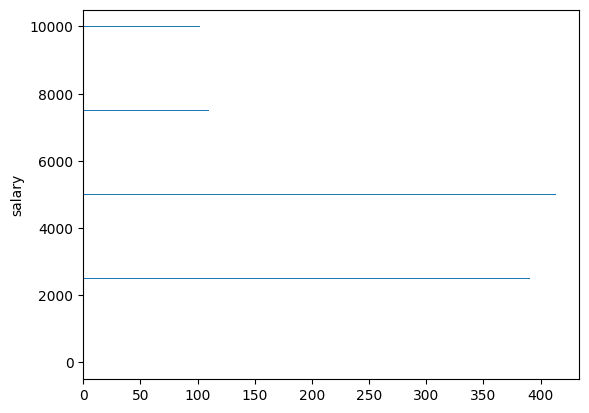

Analista         1057
Especialista      876
Asistente         703
Ejecutivo         680
Jefe              675
Practicante       588
Desarrollador     530
Gestor            428
Lider             188
Arquitecto        112
Consultor         100
Disenador          78
Administrador      68
Operador           67
Ingeniero          32
Automatizador      22
Gerente            12
Name: primaryRole, dtype: int64


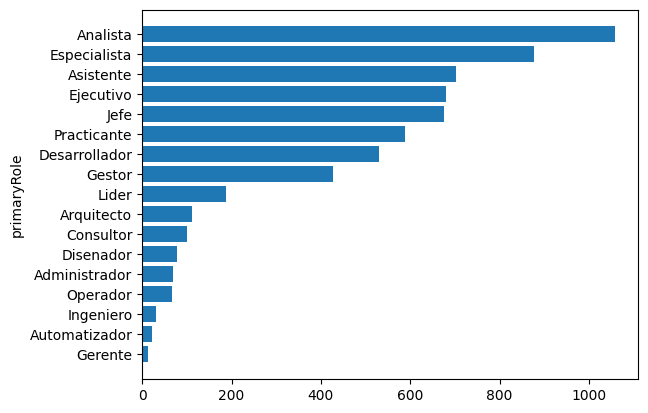

Comercial      739
Proyectos      675
Rrhh           588
Cloud          456
.Net           430
Servicios      420
Calidad        250
Desarrollo     221
Sistemas       216
Procesos       172
Analitica      171
Funcional      171
Social         132
Tecnico        130
Pmo            113
Comunidades     98
Bd              95
Office          86
Bi              85
Java            81
Name: secondaryRole, dtype: int64


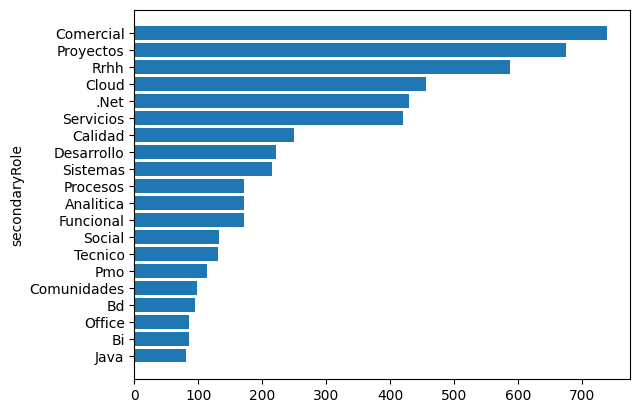

Desarrollo De Software    2076
Servicios En La Nube       916
Comercial                  837
Analitica                  831
Rrhh                       588
Operaciones                377
Modern Workplace           372
Pmo                        113
Industria 4.0              106
Name: companyArea, dtype: int64


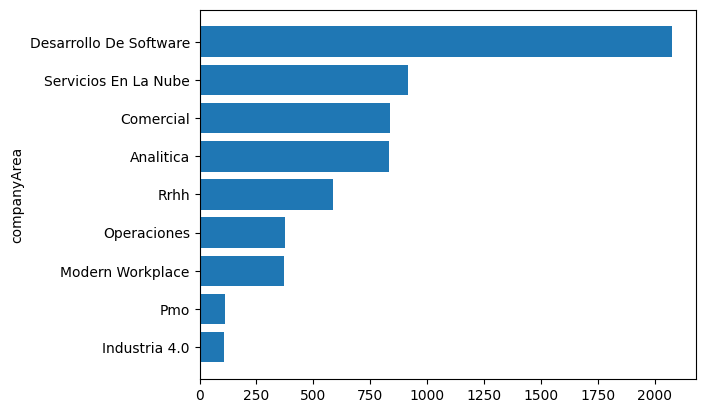

No Especificado    5598
Junior              413
Senior              188
Semi Senior          17
Name: profileLevel, dtype: int64


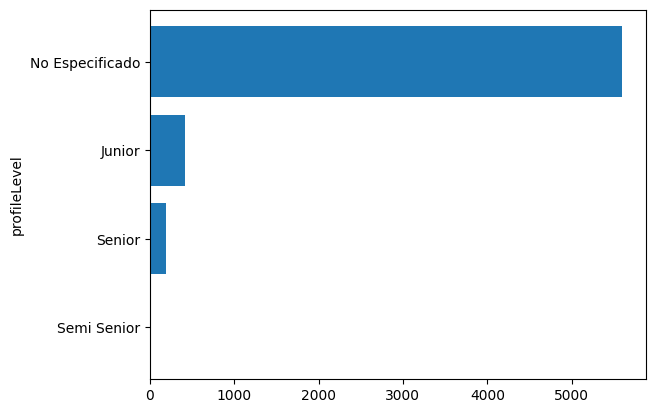

Fin: 2023-05-12 02:20:17.522639
Tiempo: 0:00:01.687193


In [86]:
if __name__ == "__main__":
  main()